In [142]:
import sys
sys.path.append("..")

from server.optimisation.models import *
from server.optimisation.gen_data import *

def getTicksForDay(id):
    day = Day.model_validate({"day": id, "deferables": getDefDemands(id)})
    ticks = []
    for tick in range(TICKS_PER_DAY):
        sun = getSunlight(tick)
        demand = getInstDemand(id, tick)
        sell, buy = getPrice(id, tick)

        ticks.append(
            Tick.model_validate(
                {
                    "tick": tick,
                    "sun": sun,
                    "demand": demand,
                    "sell_price": sell,
                    "buy_price": buy,
                    "day": id,
                }
            )
        )
    return day, ticks

In [179]:
tick_data = []
for i in range(1700):
    _, tmp = getTicksForDay(143038273 + i)
    tick_data += [[tick.day + tick.tick/60.0, tick.buy_price] for tick in tmp]

train_size = int(len(tick_data)*0.8)
tick_in_train = [[i[0] - 143038273, i[1]] for i in tick_data[:train_size-1]]
tick_out_train = [tick[1] for tick in tick_data[1:train_size]]
tick_in_test = tick_data[train_size:-1]
tick_out_test = [tick[1] for tick in tick_data[train_size + 1:]]


In [180]:
print(tick_in_train[:10])
print(tick_out_train[:10])

[[0.0, 11], [0.016666680574417114, 36], [0.03333333134651184, 29], [0.050000011920928955, 26], [0.06666666269302368, 22], [0.0833333432674408, 13], [0.09999999403953552, 15], [0.11666667461395264, 8], [0.13333332538604736, 11], [0.15000000596046448, 31]]
[36, 29, 26, 22, 13, 15, 8, 11, 31, 28]


In [181]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.set_default_tensor_type(torch.DoubleTensor)

In [182]:
class Model(nn.Module):
    def __init__(self, in_f = 2, hl1 = 20, hl2 = 20, out=1):
        super().__init__()
        self.fc1 = nn.Linear(in_f, hl1)
        self.fc2 = nn.Linear(hl1, hl2)
        self.out = nn.Linear(hl2, out)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)


In [183]:
model = Model()

In [184]:
tick_in_train

[[0.0, 11],
 [0.016666680574417114, 36],
 [0.03333333134651184, 29],
 [0.050000011920928955, 26],
 [0.06666666269302368, 22],
 [0.0833333432674408, 13],
 [0.09999999403953552, 15],
 [0.11666667461395264, 8],
 [0.13333332538604736, 11],
 [0.15000000596046448, 31],
 [0.1666666567325592, 28],
 [0.18333333730697632, 11],
 [0.19999998807907104, 33],
 [0.21666666865348816, 34],
 [0.23333331942558289, 39],
 [0.25, 53],
 [0.2666666805744171, 32],
 [0.28333333134651184, 20],
 [0.30000001192092896, 46],
 [0.3166666626930237, 30],
 [0.3333333432674408, 40],
 [0.3499999940395355, 25],
 [0.36666667461395264, 11],
 [0.38333332538604736, 13],
 [0.4000000059604645, 17],
 [0.4166666567325592, 25],
 [0.4333333373069763, 13],
 [0.44999998807907104, 12],
 [0.46666666865348816, 5],
 [0.4833333194255829, 10],
 [0.5, 5],
 [0.5166666805744171, 5],
 [0.5333333313465118, 13],
 [0.550000011920929, 6],
 [0.5666666626930237, 24],
 [0.5833333432674408, 16],
 [0.5999999940395355, 9],
 [0.6166666746139526, 12],
 [0.6

In [185]:
X_train = torch.DoubleTensor(tick_in_train)
y_train = torch.DoubleTensor([[i] for i in tick_out_train])

In [186]:
X_train

tensor([[0.0000e+00, 1.1000e+01],
        [1.6667e-02, 3.6000e+01],
        [3.3333e-02, 2.9000e+01],
        ...,
        [1.3599e+03, 3.2000e+01],
        [1.3599e+03, 3.5000e+01],
        [1.3600e+03, 2.9000e+01]])

In [187]:
y_train

tensor([[36.],
        [29.],
        [26.],
        ...,
        [35.],
        [29.],
        [ 5.]])

In [188]:
# set criterion to measure error
criterion = nn.BCEWithLogitsLoss()

# Adam Optimizer
# params = all the layers
# epoch = iteration -> sending data through the nn once
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [189]:
# training
epochs = 500
losses = []

for i in range(epochs):
    # send data forward
    y_pred = model.forward(X_train)
    print(y_train.size())
    print(y_pred.size())

    loss = criterion(y_pred, y_train)

    losses.append(loss.detach().numpy())

    print(f'epoch: {i} and loss: {loss}')

    # back propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

torch.Size([81599, 1])
torch.Size([81599, 1])
epoch: 0 and loss: -571.7244093447458
torch.Size([81599, 1])
torch.Size([81599, 1])
epoch: 1 and loss: -1513.729243867735
torch.Size([81599, 1])
torch.Size([81599, 1])
epoch: 2 and loss: -2515.808244771402
torch.Size([81599, 1])
torch.Size([81599, 1])
epoch: 3 and loss: -3573.601606462513
torch.Size([81599, 1])
torch.Size([81599, 1])
epoch: 4 and loss: -4659.352662543545
torch.Size([81599, 1])
torch.Size([81599, 1])
epoch: 5 and loss: -5845.506420318544
torch.Size([81599, 1])
torch.Size([81599, 1])
epoch: 6 and loss: -7158.00236847123
torch.Size([81599, 1])
torch.Size([81599, 1])
epoch: 7 and loss: -8627.729040460106
torch.Size([81599, 1])
torch.Size([81599, 1])
epoch: 8 and loss: -10281.069767029356
torch.Size([81599, 1])
torch.Size([81599, 1])
epoch: 9 and loss: -12126.346034878548
torch.Size([81599, 1])
torch.Size([81599, 1])
epoch: 10 and loss: -14183.791647100228
torch.Size([81599, 1])
torch.Size([81599, 1])
epoch: 11 and loss: -16479.

In [190]:
x = X_train[:100]
with torch.no_grad():
    y = model.forward(x)

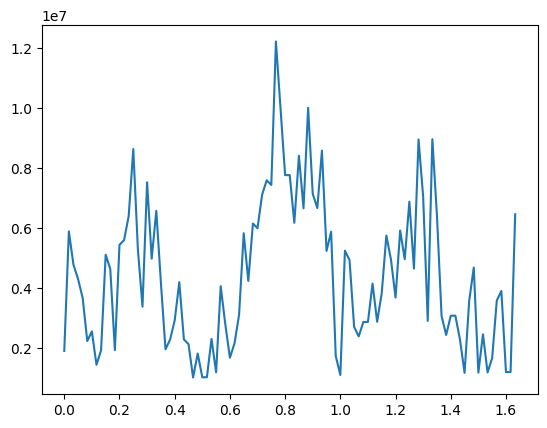

In [191]:
import matplotlib.pyplot as plt

new_x = [i[0] for i in x.numpy()]

# plt.plot([i[0] for i in x.numpy()], y.numpy())
plt.plot([i[0] for i in x.numpy()][:-1], y.numpy()[:-1])


# new_x

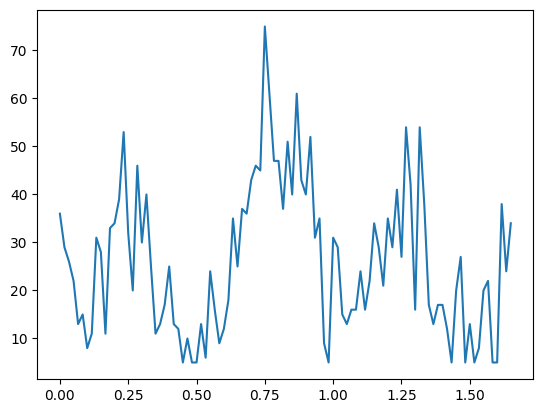

In [192]:
plt.plot([i[0] for i in x.numpy()], y_train[:100])